<a href="https://colab.research.google.com/github/gabrielfernandorey/GGGR/blob/main/LSTM/SRT%20v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRT v5 - Ensayo
### LSTM - Nuevo Dataset

In [1]:
import random
import math
import string
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


### Importamos Datos

In [39]:
!wget https://raw.githubusercontent.com/gabrielfernandorey/GGGR/main/alfanumerico_SRT.csv

--2023-05-08 14:38:30--  https://raw.githubusercontent.com/gabrielfernandorey/GGGR/main/alfanumerico_SRT.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29796040 (28M) [text/plain]
Saving to: ‘alfanumerico_SRT.csv.1’

alfanumerico_SRT.cs 100%[===================>]  28.42M  95.8MB/s    in 0.3s    

2023-05-08 14:38:32 (95.8 MB/s) - ‘alfanumerico_SRT.csv.1’ saved [29796040/29796040]



In [2]:
df = pd.read_csv('/content/alfanumerico_SRT.csv', header=0, usecols=[1,2,3,4])
df

,codigo,año,mes,total_cp
0,X5001COC,1996,5,1
1,B1602EIB,1996,7,1
2,B1625XAF,1996,7,1
3,B1651FNF,1996,7,1
4,B1688GEV,1996,7,1
...,...,...,...,...
1166442,X5901AEA,2023,5,1
1166443,X5960FLM,2023,5,1
1166444,X5971ALF,2023,5,1
1166445,Y4500XAL,2023,5,1


### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166447 entries, 0 to 1166446
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   codigo    1166447 non-null  object
 1   año       1166447 non-null  int64 
 2   mes       1166447 non-null  int64 
 3   total_cp  1166447 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 35.6+ MB


### Transformacion

In [4]:
# Columna con fecha en formato date
df['fecha'] = pd.to_datetime({'year': df['año'],
                               'month': df['mes'],
                               'day': '01'})
df

,codigo,año,mes,total_cp,fecha
0,X5001COC,1996,5,1,1996-05-01
1,B1602EIB,1996,7,1,1996-07-01
2,B1625XAF,1996,7,1,1996-07-01
3,B1651FNF,1996,7,1,1996-07-01
4,B1688GEV,1996,7,1,1996-07-01
...,...,...,...,...,...
1166442,X5901AEA,2023,5,1,2023-05-01
1166443,X5960FLM,2023,5,1,2023-05-01
1166444,X5971ALF,2023,5,1,2023-05-01
1166445,Y4500XAL,2023,5,1,2023-05-01


In [5]:
# Ordenamos por fecha
df = df.set_index('fecha')
df

,codigo,año,mes,total_cp
fecha,,,,
1996-05-01,X5001COC,1996,5,1
1996-07-01,B1602EIB,1996,7,1
1996-07-01,B1625XAF,1996,7,1
1996-07-01,B1651FNF,1996,7,1
1996-07-01,B1688GEV,1996,7,1
...,...,...,...,...
2023-05-01,X5901AEA,2023,5,1
2023-05-01,X5960FLM,2023,5,1
2023-05-01,X5971ALF,2023,5,1


In [ ]:
# Nos quedamos con aquellos codigos que tengan mas de 24 datos por codigo

### Visualizacion

In [44]:
unicos = pd.unique(df.codigo)
unicos

array(['X5001COC', 'B1602EIB', 'B1625XAF', ..., 'X5004FMM', 'X5006HWG',
       'X5011EKT'], dtype=object)

In [45]:
codigo_in = random.choice(unicos) 
codigo_in

'B8170BJC'

In [46]:
filtro = df[df.codigo == codigo_in]
filtro

,codigo,año,mes,total_cp
fecha,,,,
2016-09-01,B8170BJC,2016,9,1
2017-08-01,B8170BJC,2017,8,1
2018-03-01,B8170BJC,2018,3,1
2018-05-01,B8170BJC,2018,5,1
2021-03-01,B8170BJC,2021,3,1
2021-04-01,B8170BJC,2021,4,1
2021-06-01,B8170BJC,2021,6,1
2021-10-01,B8170BJC,2021,10,1
2022-01-01,B8170BJC,2022,1,1


In [47]:
filtro.tail(1).index[0]

Timestamp('2022-09-01 00:00:00')

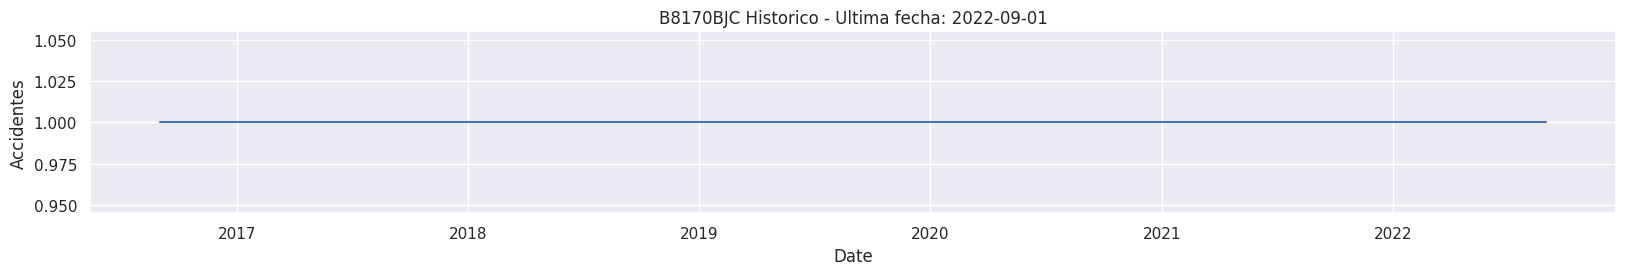

In [48]:
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico'+' - Ultima fecha: '+ str(filtro.tail(1).index[0])[:10])
plt.plot(filtro['total_cp'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

### Preparamos datos

In [49]:
data = filtro.filter(['total_cp'])

In [51]:
# Convertimos a numpy array
dataset = data.values
len(dataset)

11

### Transformar la variable de salida

In [52]:
mmscaler = MinMaxScaler()

In [53]:
data_scaled = mmscaler.fit_transform(dataset)

### Pre-entrenamiento

In [54]:
# Calculamos cantidad de datos para training y para test
training_data_len = math.ceil(len(dataset) * .8)
training_data_len 

9

In [36]:
# Prepara datos de entrenamiento
train_data = data_scaled[0:training_data_len, : ]
len(train_data)

12

In [37]:
X_train = []
y_train = []

for i in range(periodo, len(train_data)):
    X_train.append(train_data[i-periodo:i, 0])
    y_train.append(train_data[i, 0])


NameError: ignored

In [ ]:
#Convertir a numpy
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(1900, 48)

In [ ]:
#Reshape 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1900, 48, 1)

### Modelo

In [ ]:
dim_entrada = (X_train.shape[1], 1)  # dimension periodo
dim_salida = 1

modelo = Sequential()
modelo.add(LSTM(units=25, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))

In [ ]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25)                2700      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.compile(optimizer='rmsprop', loss='mse')

In [ ]:
modelo.fit(X_train, y_train, epochs=20, batch_size=16, )

Epoch 1/20
119/119 [==============================] - 6s 29ms/step - loss: 0.0199
Epoch 2/20
119/119 [==============================] - 3s 26ms/step - loss: 0.0197
Epoch 3/20
119/119 [==============================] - 3s 21ms/step - loss: 0.0197
Epoch 4/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0197
Epoch 5/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0195
Epoch 6/20
119/119 [==============================] - 4s 30ms/step - loss: 0.0196
Epoch 7/20
119/119 [==============================] - 3s 25ms/step - loss: 0.0196
Epoch 8/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0196
Epoch 9/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0196
Epoch 10/20
119/119 [==============================] - 3s 25ms/step - loss: 0.0196
Epoch 11/20
119/119 [==============================] - 4s 31ms/step - loss: 0.0196
Epoch 12/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0196
Epoch 13/20
1

### Prediccion

In [ ]:
# Ultimos valores   del dataframe a array
last_days_scaled = data_scaled[-periodo:, : ]

In [ ]:
len(data_scaled), len(last_days_scaled)

(2435, 48)

In [ ]:
X_test_new = []
X_test_new.append(last_days_scaled)
X_test_new = np.array(X_test_new)
X_test_new = np.reshape(X_test_new, (1, periodo, 1))  # Entramos con un 1 vector de dimension 'periodo'

In [ ]:
pred = modelo.predict(X_test_new)
pred = mmscaler.inverse_transform(pred)

1/1 [==============================] - 0s 455ms/step


In [ ]:
print(f"Prediccion para el código {codigo_in} para la fecha {filtro.tail(1).index[0]}: {round(pred[0][0])} incidentes")  

Prediccion para el código 5900 para la fecha 2023-05-01 00:00:00: 10 incidentes


### Visualizar

In [ ]:
X_test_new = np.reshape(X_test_new, (1, periodo))

In [ ]:
last = mmscaler.inverse_transform(X_test_new)

In [ ]:
df_incidentes = pd.DataFrame(last)

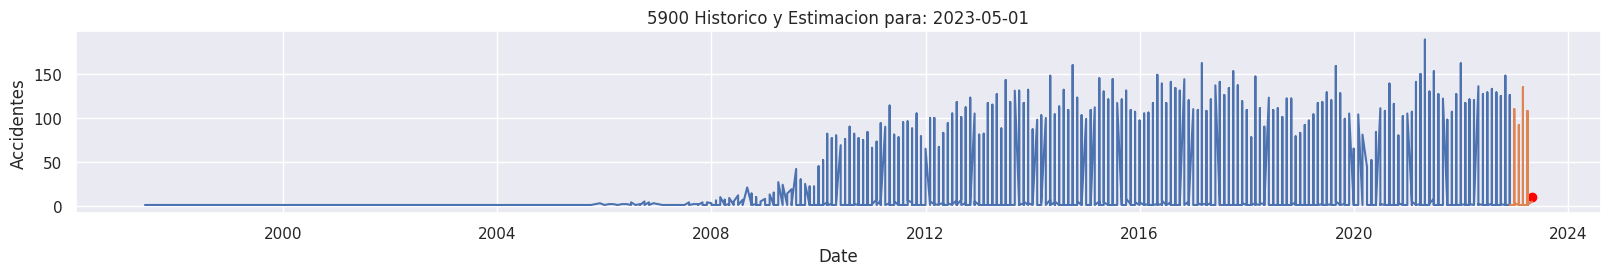

In [ ]:
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico y Estimacion para: '+ str(filtro.tail(1).index[0])[:10])
plt.plot(data[:-periodo])
plt.plot(data[-periodo:])
plt.scatter([filtro.tail(1).index[0]], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

In [ ]:
# Ultimos incidentes
df_incidentes

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,1.0,1.0,1.0,1.0,110.0,1.0,1.0,1.0,2.0,1.0,...,1.0,108.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0


In [ ]:
data[-12:]

,total_cp
fecha,
2023-04-01,1
2023-04-01,1
2023-04-01,1
2023-04-01,108
2023-04-01,1
2023-04-01,1
2023-04-01,1
2023-04-01,2
2023-04-01,1


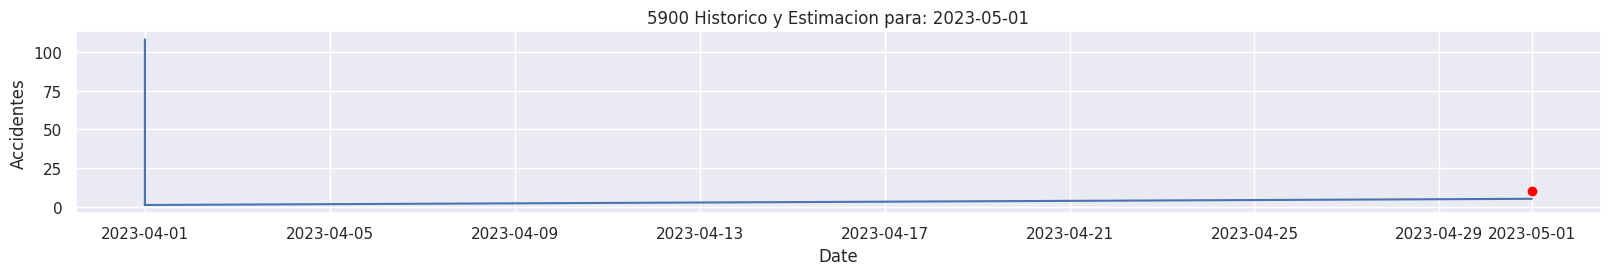

In [ ]:
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Ultimos 12 meses y Estimacion para: '+ str(filtro.tail(1).index[0])[:10])
plt.plot(data[-12:])
plt.scatter([filtro.tail(1).index[0]], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

### Evaluacion para los proximos 6 meses

In [ ]:
meses = 6

In [ ]:
X_test_new.shape

(1, 48)

In [ ]:
pred_m = []
X_test_actual = X_test_new
for m in range(meses):
  # Elimino el primer elemento
  X_test_proximo = np.delete(X_test_actual, 0, axis=1) 
  # Agregamos ultima prediccion
  X_test_proximo = np.append(X_test_proximo, round(pred[0][0]))
  # Transformo
  X_test_proximo = mmscaler.transform(X_test_proximo.reshape(-1, 1))
  X_test_proximo = np.reshape(X_test_proximo, (1, periodo, 1))  # Entramos con un 1 vector de dimension periodo
  pred = modelo.predict(X_test_proximo)
  pred = mmscaler.inverse_transform(pred)
  pred_m.append(round(pred[0][0]))
  X_test_actual = X_test_proximo


1/1 [==============================] - 0s 26ms/step


In [ ]:
pred_m

[1, 1, 1, 1, 1, 1]

In [ ]:
fechas = []
fechas = [filtro.tail(1).index[0] + pd.DateOffset(months=n) for n in range(meses) ]

In [ ]:
estim = pd.DataFrame({'fecha':fechas, 'estimacion':pred_m}).set_index('fecha')
estim

,estimacion
fecha,
2023-04-01,1
2023-05-01,1
2023-06-01,1
2023-07-01,1
2023-08-01,1
2023-09-01,1


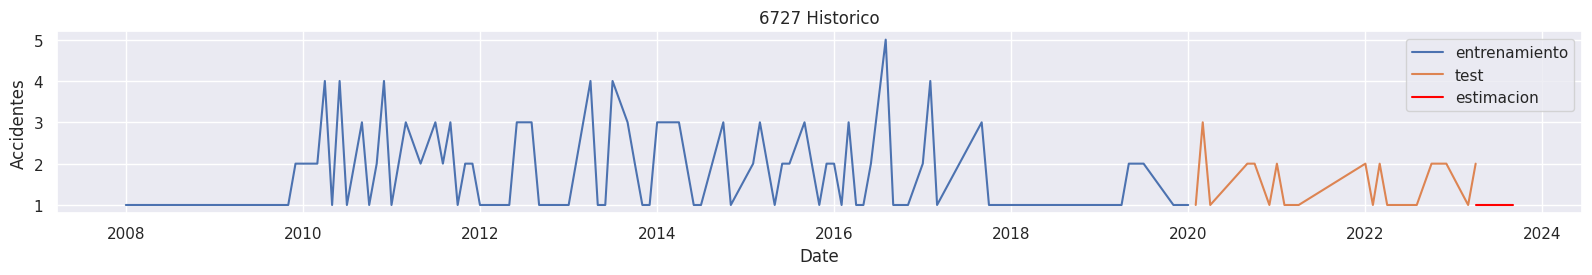

In [ ]:
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico')
plt.plot(filtro['total_cp'][:training_data_len], label='entrenamiento')
plt.plot(filtro['total_cp'][training_data_len:], label='test')
plt.plot(estim['estimacion'],color='red', label='estimacion')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12)
plt.legend();